In [3]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd
import numpy as np
import matplotlib.patches
import geopandas as gpd

In [4]:
# Load the hydropower data
path = "/home/shah0012/GloHydroRes/Output_data/"
glohydrores_data = pd.read_excel(path + "glohydrores_v1.xlsx",  header = 0, sheet_name = "data")

print(glohydrores_data.head())

         ID      country                                               name  \
0  GHR00001  Afghanistan       Kajaki Hydroelectric Power Plant Afghanistan   
1  GHR00002  Afghanistan      Mahipar Hydroelectric Power Plant Afghanistan   
2  GHR00003  Afghanistan   Naghlu Dam Hydroelectric Power Plant Afghanistan   
3  GHR00004  Afghanistan  Nangarhar (Darunta) Hydroelectric Power Plant ...   
4  GHR00005  Afghanistan  Pul-e-Khumri Hydroelectric Power Plant Afghani...   

   capacity_mw  plant_lat  plant_lon plant_type  \
0       151.00    32.3220    65.1190        STO   
1        66.00    34.5560    69.4787        STO   
2       100.00    34.6410    69.7170        ROR   
3        11.55    34.4847    70.3633        STO   
4         6.00    35.9416    68.7100        ROR   

                                   plant_type_source    year plant_source  \
0  https://www.power-technology.com/data-insights...  1975.0          WRI   
1    https://globalenergyobservatory.org/geoid/40541  1967.0    

#### Compare installed capacity of each country available in hydropower dataset with IRENA and EIA data

In [5]:
# I replaced all the "-" with 0 in the excel file manually
IRNEA_hydropower_installed_capacity = pd.read_excel(
    "/home/shah0012/GloHydroRes/Input_data/IRENA_data/IRENA_hydropower_2023.xlsx", header=2, names = ["Country", "hydropower_installed_capacity", "pumped_storage_capacity"]
)
IRNEA_hydropower_installed_capacity.rename(columns={"Unnamed: 0": "Country"}, inplace=True)
IRNEA_hydropower_installed_capacity = IRNEA_hydropower_installed_capacity.dropna() # Drop rows with NaN values
IRNEA_hydropower_installed_capacity["hydropower_installed_capacity"] = IRNEA_hydropower_installed_capacity["hydropower_installed_capacity"].astype(float)
IRNEA_hydropower_installed_capacity["pumped_storage_capacity"] = IRNEA_hydropower_installed_capacity["pumped_storage_capacity"].astype(float)
IRNEA_hydropower_installed_capacity["total_capacity"] = IRNEA_hydropower_installed_capacity["hydropower_installed_capacity"] + IRNEA_hydropower_installed_capacity["pumped_storage_capacity"]

In [6]:
# This file provides the country unique ID and the country shapes
country_shape = gpd.read_file(
    "/home/shah0012/GloHydroRes/Input_data/Countryshapefile/vector/countries_5arcmin_shp/countries_5arcmin_with_ice_sheets.shp"
)

# This file provides the country unique ID and the country names with shapes
country_id_data  = pd.read_csv(
    "/home/shah0012/GloHydroRes/Input_data/Countryshapefile/vector/countries_id_regions.csv"
)

# Mapping the country ID to the country names
country_shape["Country"] =  country_shape.countries_.map(dict(zip(country_id_data.ID, country_id_data.Name)))
country_shape = country_shape.dropna()

In [7]:
# Matching the country names in the shape file with the country names in the hydropower data
shape_file_country_list = country_shape["Country"].unique().tolist()

In [9]:
# To match string names of shape file countries with the hydropower data countries, Levenshtein distance was used.
from fuzzywuzzy import fuzz

# Selecting unique country names from the hydropower data
hydropower_country_list = glohydrores_data[~pd.isna(glohydrores_data.country)].drop_duplicates(subset=["country"]).country.tolist()

# Matching the country names in the hydropower data with country names in the shape file. Here match each hydropower country name with all the shape file country names and select the one with the highest similarity score
shape_file_hydropower_country_match = [
    max([(fuzz.token_set_ratio(i, j), j) for j in shape_file_country_list])
    for i in hydropower_country_list
]


# Creating dictionary of hydropower country names and shape file country names
similarity_score, fuzzy_match = map(list, zip(*shape_file_hydropower_country_match))
shape_file_hydropower_plant_names_dict = {
    hydropower_country_list[i]: fuzzy_match[i]
    for i in range(len(hydropower_country_list))

}

# this was done for manual inspection to check if the fuzzy matching was correct
#pd.DataFrame(list(shape_file_hydropower_plant_names_dict.items()), columns=['Hydropower Country', 'Shape Country']).to_excel("/home/shah0012/Paper_1_related_data/IRENA_data/Shape_hydropower_country_match.xlsx")

# This resulted in the following manual corrections
shape_file_hydropower_plant_names_dict["Democratic Republic of the Congo"] = 'Congo DRC'
shape_file_hydropower_plant_names_dict["Equatorial Guinea"] = 'Equatorial Guinea'
shape_file_hydropower_plant_names_dict["Guinea"] = "Guinea"
shape_file_hydropower_plant_names_dict["Syrian Arab Republic"] = "Syria"

# Inverting the dictionary with key is shape file country name and value is hydropower country name
shape_file_hydropower_plant_names_dict = {v: k for k, v in shape_file_hydropower_plant_names_dict.items()}


country_shape["hyd_country"] = country_shape["Country"].map(shape_file_hydropower_plant_names_dict)


hydropower_country_list = glohydrores_data[~pd.isna(glohydrores_data.country)].drop_duplicates(subset=["country"]).country.tolist()
IRENA_country_list =  IRNEA_hydropower_installed_capacity.Country.tolist()

IRENA_country_hydropower_country_match = [
    max([(fuzz.token_set_ratio(i, j), j) for j in IRENA_country_list])
    for i in hydropower_country_list
]


# Creating dictionary with key as hydropower country name and values as IRENA country name
similarity_score, fuzzy_match = map(list, zip(*IRENA_country_hydropower_country_match))
IRNEA_hydropower_plant_names_dict = {
    hydropower_country_list[i]: fuzzy_match[i]
    for i in range(len(hydropower_country_list))

}

# this was done for manual inspection to check if the fuzzy matching was correct
#pd.DataFrame(list(IRNEA_hydropower_plant_names_dict.items()), columns=['Hydropower Country', 'IRENA Country']).to_excel("/home/shah0012/Paper_1_related_data/IRENA_data/IRENA_hydropower_country_match.xlsx")


# I manually corrected the fuzzy matching in the excel file
IRNEA_hydropower_plant_names_dict["Equatorial Guinea"] = "Equatorial Guinea"
IRNEA_hydropower_plant_names_dict["Georgia"] = "Georgia"
IRNEA_hydropower_plant_names_dict["Czech Republic"] = "Czechia"
IRNEA_hydropower_plant_names_dict["Guinea"] = "Guinea"
IRNEA_hydropower_plant_names_dict["Ireland"] = "Ireland"
IRNEA_hydropower_plant_names_dict["Laos"] = "Lao People's Democratic Republic (the)"
IRNEA_hydropower_plant_names_dict["North Korea"] = "Democratic People's Republic of Korea (the)"
IRNEA_hydropower_plant_names_dict["Russia"] = "Russian Federation (the)"
IRNEA_hydropower_plant_names_dict["South Korea"] = "Republic of Korea (the)"
IRNEA_hydropower_plant_names_dict["Taiwan"] = "Chinese Taipei"
IRNEA_hydropower_plant_names_dict["Vietnam"] = "Viet Nam"
IRNEA_hydropower_plant_names_dict["Congo"] = "Congo (the)"
IRNEA_hydropower_plant_names_dict["China"] = "China"	



country_shape["IRENA_country"] = country_shape["hyd_country"].map(IRNEA_hydropower_plant_names_dict)



# Grouped hydropower data by country
hydropower_data_country = glohydrores_data.groupby("country")["capacity_mw"].sum().reset_index()
country_shape["hyd_installed_cap"] =  country_shape.hyd_country.map(dict(zip(hydropower_data_country.country, hydropower_data_country.capacity_mw)))
print(country_shape["hyd_installed_cap"])



# Merging the IRENA data with the shape file data
country_shape["IRENA_instaled_cap"] = country_shape.IRENA_country.map(dict(zip(IRNEA_hydropower_installed_capacity.Country, IRNEA_hydropower_installed_capacity.total_capacity)))


# Calculating the proportion of hydropower capacity installed in each country
country_shape["hyd_prportion_covered"] = (country_shape["hyd_installed_cap"]/country_shape["IRENA_instaled_cap"])*100


# Plotting the proportion of hydropower capacity installed in each country
country_shape["hyd_prportion_covered"][country_shape["hyd_prportion_covered"] == np.inf] = np.nan


0        356.550
1       2074.966
2        232.000
3            NaN
4            NaN
         ...    
211    17666.000
212    16746.000
213          NaN
214     3166.800
215     1079.250
Name: hyd_installed_cap, Length: 216, dtype: float64


In [10]:
countries_continent_names = pd.read_csv("/home/shah0012/GloHydroRes/Input_data/Countryshapefile/Countries-Continents.csv")
countries_continent_dict = dict(zip(countries_continent_names["Country"], countries_continent_names["Continent"]))

# Assigning continent names to the countries in the shape file country id data
country_shape["Continent_name"] = country_shape.Country.map(countries_continent_dict)
print(country_shape.Country[pd.isna(country_shape["Continent_name"])])

3                  American Samoa
9                           Aruba
21                        Bermuda
27         British Virgin Islands
30                   Burkina Faso
32                     Cabo Verde
36                 Cayman Islands
43                      Congo DRC
44                 Congo Republic
46                  Cote d Ivoire
49                        Curacao
51                 Czech Republic
62                       Eswatini
64                  Faroe Islands
68                  French Guiana
69               French Polynesia
75                      Gibraltar
78                           Guam
85                      Hong Kong
93                    Isle of Man
102                        Kosovo
114                         Macao
132                       Myanmar
137                 New Caledonia
142                   North Korea
143               North Macedonia
144      Northern Mariana Islands
149                     Palestine
159                        Russia
161           

In [11]:
# For some countries the continent names were not available. Hence, I manually assigned the continent names
remain_country_continent_dict = {"American Samoa" : "Oceania",
"Aruba" : "North America",
"Bermuda" : "North America",
"British Virgin Islands" : "North America",
"Burkina Faso" : "Africa",
"Cabo Verde" : "Africa",
"Cayman Islands" : "North America",
"Congo DRC"  : "Africa",
"Congo Republic" : "Africa",
"Cote d Ivoire"   : "Africa",
"Curacao" : "South America",
"Czech Republic" : "Europe",
"Eswatini" : "Africa",
"Faroe Islands" : "Europe",
"French Guiana" :   "South America",
"French Polynesia"   : "Oceania",
"Gibraltar" : "Europe",
"Guam" : "Oceania",
"Hong Kong" : "Asia",
"Isle of Man" : "Europe",
"Kosovo" : "Europe",
"Macao" : "Asia",
"Myanmar" : "Asia",
"New Caledonia" : "Oceania",
"North Korea" : "Asia",
"Timor-Leste" : "Asia",
"Turks and Caicos Islands" : "North America",
"United States Virgin Islands" : "North America",
"United States" : "North America",
"North Macedonia" : "Europe",
"Northern Mariana Islands" :  "Oceania",
"Palestine" :  "Asia",
"Russia" : "Asia",
"Sahrawi Republic" :  "Africa",
"Sint Maarten (Netherlands)"   : "North America",
"South Korea"   : "Asia",
"Taiwan" : "Asia"}

final_country_continent_dict = dict(countries_continent_dict, **remain_country_continent_dict)  

In [12]:
# Assigning continent names to the countries in the shape file country id data
country_shape["Continent_name"] = country_shape.Country.map(final_country_continent_dict)
country_shape.Continent_name[country_shape.Country == "US Virgin Islands"] = "North America"

In [13]:
# Here we will use the EIA data of 2022
# Units are in million kilowatt which GigaWatt 
EIA_USA_pumped_storage_installed_capacity = pd.read_csv(
    "/home/shah0012/GloHydroRes/Input_data/EIA_US/EIA_USA_hydropower_pump_storage_2022_23.csv", header=1
)

EIA_USA_pumped_storage_installed_capacity = EIA_USA_pumped_storage_installed_capacity.iloc[2:, [1, 2]]
EIA_USA_pumped_storage_installed_capacity.rename(columns={"Unnamed: 1": "Country", '2022' : 'pump_storage'}, inplace=True)
EIA_USA_pumped_storage_installed_capacity['pump_storage'] = pd.to_numeric(EIA_USA_pumped_storage_installed_capacity['pump_storage'], errors='coerce')
print(EIA_USA_pumped_storage_installed_capacity.shape)

EIA_USA_hydropower_installed_capacity = pd.read_csv(
    "/home/shah0012/GloHydroRes/Input_data/EIA_US/EIA_USA_hydropower_2022_23.csv", header=1
)

EIA_USA_hydropower_installed_capacity = EIA_USA_hydropower_installed_capacity.iloc[2:, [1,3]]
EIA_USA_hydropower_installed_capacity.rename(columns={"Unnamed: 1": "Country", '2022' : 'conventional_hydro'}, inplace=True)
EIA_USA_hydropower_installed_capacity['conventional_hydro'] = pd.to_numeric(EIA_USA_hydropower_installed_capacity['conventional_hydro'], errors='coerce')
print(EIA_USA_pumped_storage_installed_capacity.shape)

EIA_USA_hydropower_installed_capacity = EIA_USA_hydropower_installed_capacity.merge(EIA_USA_pumped_storage_installed_capacity, on="Country", how="outer")


EIA_USA_hydropower_installed_capacity["total_capacity"] = EIA_USA_hydropower_installed_capacity["conventional_hydro"] + EIA_USA_hydropower_installed_capacity["pump_storage"]


EIA_USA_hydropower_installed_capacity["Country"] = EIA_USA_hydropower_installed_capacity["Country"].apply(lambda x: x.strip())

(230, 2)
(230, 2)


In [14]:
# Matching the country names in the shape file with the country names in the hydropower data
EIA_USA_country_name_list = EIA_USA_hydropower_installed_capacity["Country"].unique().tolist()

# To match string names of shape file countries with the hydropower data countries, Levenshtein distance was used.
from fuzzywuzzy import fuzz

# Selecting unique country names from the hydropower data
hydropower_country_list = country_shape[~pd.isna(country_shape.hyd_country)].hyd_country.tolist()


# Matching the country names in the hydropower data with country names in the shape file. Here match each hydropower country name with all the shape file country names and select the one with the highest similarity score
EIA_US_hydropower_country_match = [
    max([(fuzz.token_set_ratio(i, j), j) for j in EIA_USA_country_name_list])
    for i in hydropower_country_list
]


# Creating dictionary of hydropower country names and shape file country names
similarity_score, fuzzy_match = map(list, zip(*EIA_US_hydropower_country_match))
EIA_hydropower_plant_names_dict = {
    hydropower_country_list[i]: fuzzy_match[i]
    for i in range(len(hydropower_country_list))

}



#pd.DataFrame(list(EIA_hydropower_plant_names_dict.items()), columns=['Hydropower Country', 'EIA Country']).to_excel("/home/shah0012/Paper_1_related_data/EIA_US/EIA_hydropower_country_match_uncleaned.xlsx")


# I manually corrected the fuzzy matching in the excel file
EIA_hydropower_plant_names_dict["Democratic Republic of the Congo"] = "Congo-Kinshasa"
EIA_hydropower_plant_names_dict["Congo"] = "Congo-Brazzaville"
EIA_hydropower_plant_names_dict["Czech Republic"] = "Czechia"
EIA_hydropower_plant_names_dict["Equatorial Guinea"] = "Equatorial Guinea"
EIA_hydropower_plant_names_dict["Germany"] = "Germany"
EIA_hydropower_plant_names_dict["Guinea"] = "Guinea"
EIA_hydropower_plant_names_dict["Syrian Arab Republic"] = "Syria"
del EIA_hydropower_plant_names_dict["Myanmar"]


#pd.DataFrame(list(EIA_hydropower_plant_names_dict.items()), columns=['Hydropower Country', 'EIA Country']).to_excel("/home/shah0012/Paper_1_related_data/EIA_US/EIA_hydropower_country_match_cleaned.xlsx")

country_shape["EIA_country"] = country_shape["hyd_country"].map(EIA_hydropower_plant_names_dict)


# Merging the EIA data with the shape file data
country_shape["EIA_instaled_cap"] = country_shape.EIA_country.map(dict(zip(EIA_USA_hydropower_installed_capacity.Country, EIA_USA_hydropower_installed_capacity.total_capacity)))


# Calculating the proportion of hydropower capacity installed in each country
country_shape["EIA_prportion_covered"] = ((country_shape["hyd_installed_cap"]/1000)/country_shape["EIA_instaled_cap"])*100


# Plotting the proportion of hydropower capacity installed in each country
country_shape["EIA_prportion_covered"][country_shape["EIA_prportion_covered"] == np.inf] = np.nan

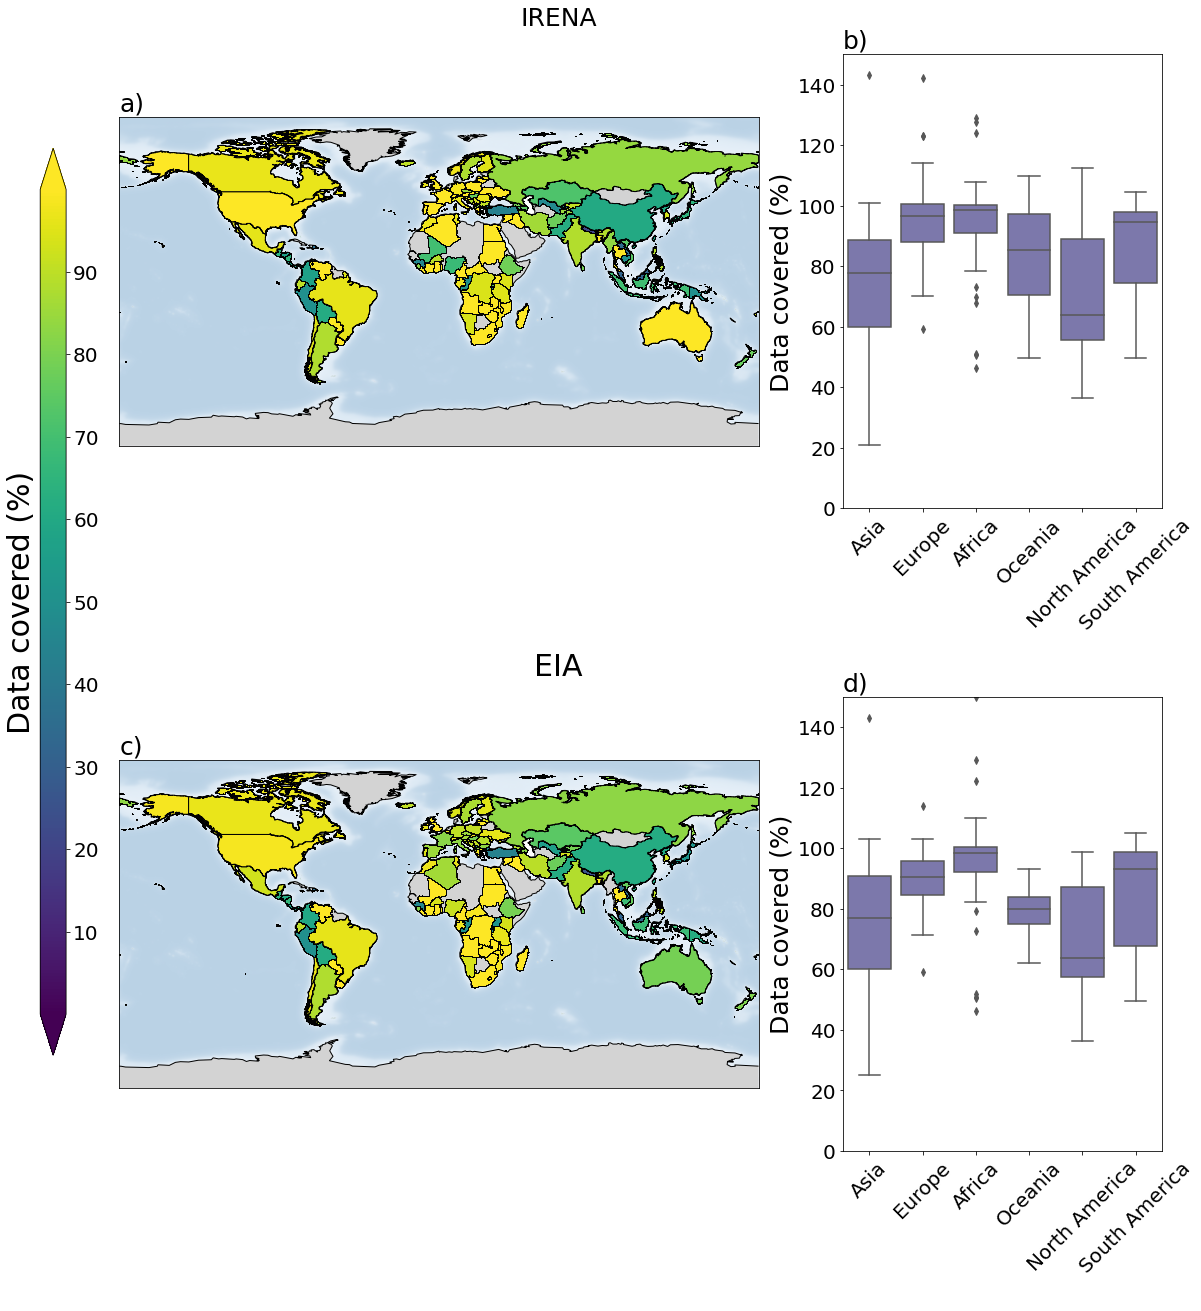

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import matplotlib as mpl

# Define the figure and GridSpec
fig = plt.figure(figsize=[18, 18])
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1.5]) # Here width_ratios is used to adjust the width of the subplots. So the first column (spatial  plot) is wider (3/(3 + 1.5)) than the second column (boxplot)


# # Create a ScalarMappable object for the colorbar
norm = mpl.colors.Normalize(vmin=0, vmax=100)
cmap = mpl.cm.viridis
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# For IRENA spatial plot
ax0 = fig.add_subplot(gs[0, 0])
m = Basemap(
    projection="cyl",
    llcrnrlat=-90,
    urcrnrlat=90,
    llcrnrlon=-180,
    urcrnrlon=180,
    resolution="c",
    ax=ax0,
)
m.drawcoastlines()
m.fillcontinents(color="lightgray", zorder=1)
m.shadedrelief(scale=0.2, alpha=0.5)
pos = country_shape.plot(ax=ax0, edgecolor="black", vmin=0, vmax=100, legend=False, column="hyd_prportion_covered", cmap="viridis", zorder=5, linewidth=1)
ax0.set_title('a)', loc='left', fontsize=25)


# For IRENA boxplot
ax1 = fig.add_subplot(gs[0, 1])
sns.boxplot(x='Continent_name', y='hyd_prportion_covered', data=country_shape, color="#7570b3", ax=ax1)
ax1.set_xlabel(" ", fontsize=25)
ax1.set_ylabel("Data covered (%)", fontsize=25)
ax1.set_ylim(0, 150)
ax1.tick_params(axis='x', rotation=45, labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_title('b)', loc='left', fontsize=25)

fig.text(0.5, 1, 'IRENA', ha='center', va='center', fontsize=25)

# For EIA spatial plot
ax2 = fig.add_subplot(gs[1, 0])
m = Basemap(
    projection="cyl",
    llcrnrlat=-90,
    urcrnrlat=90,
    llcrnrlon=-180,
    urcrnrlon=180,
    resolution="c",
    ax=ax2,
)
m.drawcoastlines()
m.fillcontinents(color="lightgray", zorder=1)
m.shadedrelief(scale=0.2, alpha=0.5)
pos1 = country_shape.plot(ax=ax2, edgecolor="black", vmin=0, vmax=100, legend=False, column="EIA_prportion_covered", cmap="viridis", zorder=5, linewidth=1)
ax2.set_title('c)', loc='left', fontsize=25)

# For EIA boxplot
ax3 = fig.add_subplot(gs[1, 1])
sns.boxplot(x='Continent_name', y='EIA_prportion_covered', data=country_shape, color="#7570b3", ax=ax3)
ax3.set_xlabel(" ", fontsize=25)
ax3.set_ylabel("Data covered (%)", fontsize=25)
ax3.set_ylim(0, 150)
ax3.tick_params(axis='x', rotation=45, labelsize=20)
ax3.tick_params(axis='y', labelsize=20)
ax3.set_title('d)', loc='left', fontsize=25)

fig.text(0.5, 0.5, 'EIA', ha='center', va='center', fontsize=30)

# Add the common colorbar on the left side
cbar_ax = fig.add_axes([0.1, 0.2, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, extend="both", ticks=np.arange(10, 100, 10))
cbar.set_label('Data covered (%)', fontsize=30)
cbar.ax.tick_params(labelsize=20)
cbar.ax.yaxis.set_label_position('left') # This will move the colorbar label to the left. If not used, the label will be on the right side of the colorbar
plt.tight_layout(rect=[0.15, 0, 1, 1])  # Adjust the layout to make space for the colorbar


plt.savefig(
     "/home/shah0012/GloHydroRes/Figure/IRENA_EIA_GloHydroRes_comparison.png",
     bbox_inches="tight",
 )


In [ ]:
print(country_shape.EIA_prportion_covered[country_shape.Continent_name == "Africa"].median())
print(country_shape.EIA_prportion_covered[country_shape.Continent_name == "Europe"].median())
print("Costa Rica representation is {}".format(country_shape.EIA_prportion_covered[country_shape.hyd_country == "Costa Rica"].iloc[0]))
print("Honduras representation is {}".format(country_shape.EIA_prportion_covered[country_shape.hyd_country == "Honduras"].iloc[0]))
print("Panama representation is {}".format(country_shape.EIA_prportion_covered[country_shape.hyd_country == "Panama"].iloc[0]))
print("Bolivia representation is {}".format(country_shape.EIA_prportion_covered[country_shape.hyd_country == "Bolivia"].iloc[0]))
print("Colombia representation is {}".format(country_shape.EIA_prportion_covered[country_shape.hyd_country == "Colombia"].iloc[0]))
print("Peru representation is {}".format(country_shape.EIA_prportion_covered[country_shape.hyd_country == "Peru"].iloc[0]))
print("Brazil representation is {}".format(country_shape.EIA_prportion_covered[country_shape.hyd_country == "Brazil"].iloc[0]))
print("Paraguay representation is {}".format(country_shape.EIA_prportion_covered[country_shape.hyd_country == "Paraguay"].iloc[0]))
print("Uruguay representation is {}".format(country_shape.EIA_prportion_covered[country_shape.hyd_country == "Uruguay"].iloc[0]))
print("Venezuela representation is {}".format(country_shape.EIA_prportion_covered[country_shape.hyd_country == "Venezuela"].iloc[0]))
print(country_shape.EIA_prportion_covered[country_shape.Continent_name == "Asia"].median())
print(country_shape.EIA_prportion_covered[country_shape.Continent_name == "Asia"].median())
print((country_shape.hyd_installed_cap/1000).sum()/country_shape.EIA_instaled_cap.sum())
#print(country_shape.columns)
Africa_country = country_shape[country_shape.Continent_name == "Africa"]
Africa_country[Africa_country.hyd_prportion_covered > 100]
European_country = country_shape[country_shape.Continent_name == "Europe"]
European_country[European_country.hyd_prportion_covered > 100]
European_country[European_country.EIA_prportion_covered > 100]
#European_country.EIA_prportion_covered.median()
#Africa_country.hyd_prportion_covered.median()
#European_country[European_country.EIA_prportion_covered > 100]